[*********************100%***********************]  1 of 1 completed


1946
195
Index(['Volume', 'MACD_HIST', 'Target'], dtype='object', name='Price')
                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4661
Date:                Sun, 14 Dec 2025   Prob (F-statistic):              0.628
Time:                        12:38:14   Log-Likelihood:                 180.56
No. Observations:                 194   AIC:                            -355.1
Df Residuals:                     191   BIC:                            -345.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

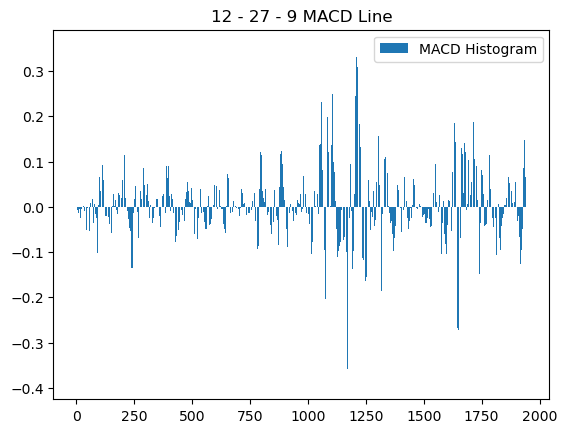

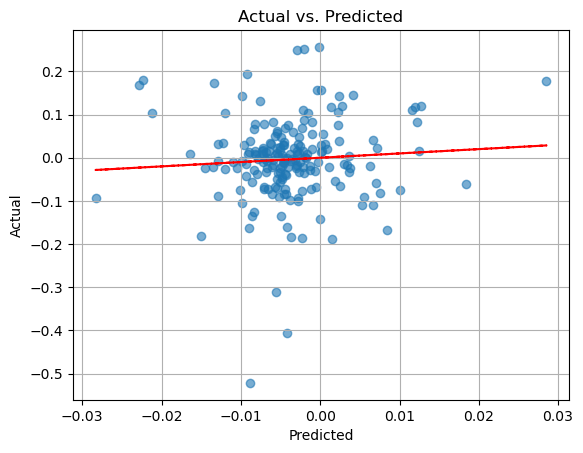


[Overall Model Significance] p-value = 0.628129


Price,Close,High,Low,Open,Volume,Target,12_ema,27_ema,MACD,Signal,MACD_HIST,Predictions,Residuals
0,686.369995,686.640015,686.059998,686.590027,1408772,-0.065564,686.369995,686.369995,0.000000,0.000000,0.000000,0.002479,-0.068043
1,685.919983,686.000000,685.650024,685.809998,253360,-0.048949,686.016341,686.055080,-0.038739,-0.024107,-0.014632,-0.004871,-0.044079
2,685.584229,685.809875,685.450012,685.510010,166089,-0.022497,685.714646,685.803167,-0.088521,-0.066346,-0.022175,-0.006028,-0.016469
3,685.429993,685.510010,685.346191,685.419983,123920,-0.049599,685.573266,685.664066,-0.090801,-0.076635,-0.014166,-0.005497,-0.044101
4,685.090027,685.239990,685.044983,685.239990,106429,-0.010219,685.380813,685.505849,-0.125036,-0.094142,-0.030894,-0.007153,-0.003066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,681.820007,681.979980,681.809998,681.889893,132217,0.018333,681.967229,681.920450,0.046778,0.056932,-0.010153,-0.005079,0.023412
191,681.945007,681.979980,681.830017,681.835022,142636,-0.135640,681.878423,681.885628,-0.007204,0.002201,-0.009406,-0.004955,-0.130684
192,681.020020,681.049988,680.559998,680.659973,285806,-0.026475,681.148188,681.442795,-0.294606,-0.201995,-0.092612,-0.011996,-0.014479
193,680.839722,681.059998,680.695007,680.969971,290875,0.076567,680.803792,681.040890,-0.237099,-0.296385,0.059287,0.002236,0.074331


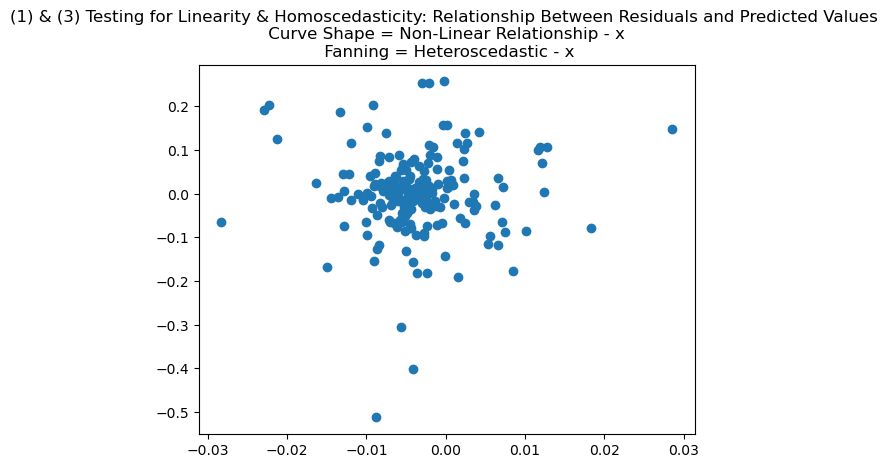

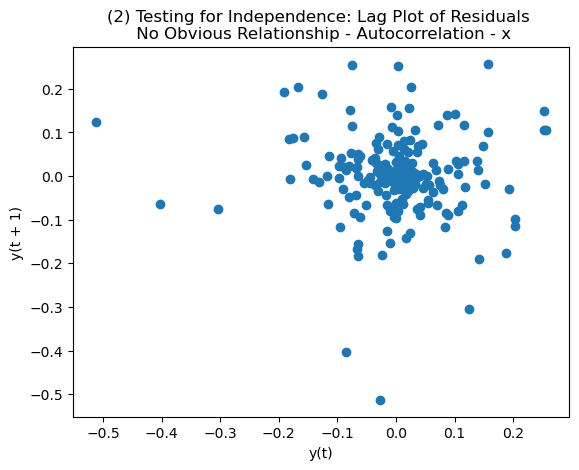

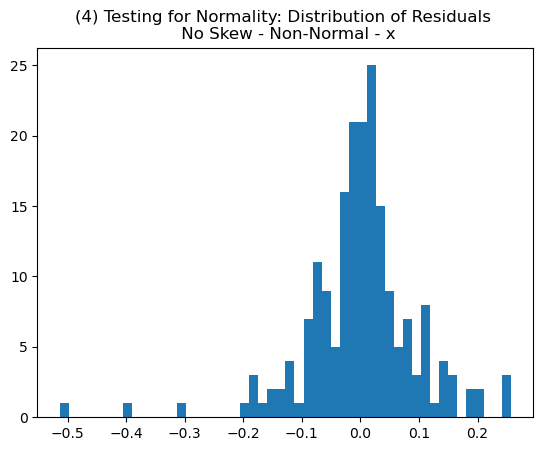

In [4]:
# Switching from SciKit Learn Lib to Stats Models Lib for cleaner results

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
    # p-Value is better acessible in this library 
import statsmodels.api as sm

# --- (0) GLOBALEN PARAMETERS ---

# Schritt 1: Ticker
TICKER = "SPY"

# Schritt 2: Preisverhalten 
INTERVAL = "1m"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

# Schritt 3: Strategie/Unabhängige Variable (FGV)
STRATEGY = ["Volume", "MACD_HIST"]
# FVG is bullshit, so we do not use it 
# Step 3: MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# Schritt 4: Verschieben von Reihen in der Vergangenheit
SHIFT = 10

# Verbindung der SHIFT-Variablen, in Ihrem Code verwenden Sie SHIFT = 10 für zwei verschiedene Zwecke:
#   In add_target: Es definiert, wie weit in die Zukunft Sie schauen (Close in 10 Perioden minus Close heute).
#       Sinn: Sie versuchen, die Preisänderung über die nächsten 10 Perioden vorherzusagen.
#   In fix_autocorrelation: Es definiert die Abtastfrequenz (Down-Sampling).
#       Sinn: Da Sie über 10 Perioden vorhersagen, filtern Sie die Daten so, dass sich die Zielperioden nicht überlappen und die Beobachtungen unabhängig bleiben.

# Schritt 5: Datenteilmenge (Wie viele Zeilen werden wir analysieren)
LOOKBACK = 10000

# --- (1) Daten herunterladen in df ---

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Daten herunterladen
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Nur Level 0 of Multilevel Columns selecten
    df.columns = df.columns.get_level_values(0)

    # Step 3: df for Plots vereinfachen (Index statt Datum)
    df = df.reset_index(drop=True)

    # Step 4: Nur LOOKBACK Reihen zurückgeben
    return df.iloc[-lookback:, :]

# --- (2) Abhängige Variable ("Target") definieren ---

def add_target(df, shift = SHIFT):

    # Schritt 1: Delta/Preisverhalten definieren (Morgen - Heute), in percentage Terms * 100
    df["Target"] = (df["Close"].shift(-shift) - df["Close"])/df["Close"] * 100

    # Step 2: df zurückgeben 
    return df

# --- (3) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    # Step 1: Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    # Step 2: MACD Column (= Difference betwenn fast and slow ema)
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    # Step 3: MACD Signal (= Span Period)
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    # Step 4: MACD Hist
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    # Step 5: Plot Histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
        # Every Bar = Every Date in the Index
        # Direction: Bar (>0) --> Bullish vs. Bar (<0) --> Bearish
        # Strength: Bar (Tall) --> Strong Momentum vs. Bar (Short) --> Weak Momentum
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

# --- (3) Solve for Autocrrelation Function ---

def fix_autocorrelation(df, interval=SHIFT):
    #print the nr of rows we had initially:
    print(len(df))
    df = df.iloc[::interval].reset_index(drop=True)
    #print the nr of rows we had afterwards:
    print(len(df))
    return df 

# Der statistische Hintergrund: Autokorrelation
# In einer korrekten Regression (OLS) müssen die Fehler (Residuen) des Modells unabhängig voneinander sein. Das ist eine der vier Hauptvoraussetzungen.
# Problem: Bei Finanzdaten sind die Kurse heute stark mit den Kursen von gestern korreliert (Aktien bewegen sich nicht zufällig). 
#   Diese Korrelation überträgt sich oft auf die Modellfehler (Residuen). Wenn der Fehler heute positiv ist, ist der Fehler morgen wahrscheinlich auch positiv.
# Konsequenz: Wenn die Fehler autokorreliert sind, sind die berechneten P-Werte (Signifikanz) des Modells ungenau und zu optimistisch. 
#   Sie erhalten möglicherweise einen P-Wert von 0.001, obwohl er in Wirklichkeit 0.3 betragen sollte. Das Modell ist dann statistisch ungültig.

# Lösung (== Down-Sampling): Wenn Sie SHIFT = 10 setzen und die Funktion ausführen, wählt der Befehl df.iloc[::10] nur jede 10. Zeile des DataFrames aus.
#   Wenn Sie nur jede 10. Stunde oder jeden 10. Tag verwenden, ist die Wahrscheinlichkeit extrem hoch, dass die Kursbewegung von Tag 1 statistisch unabhängig von der Kursbewegung von Tag 11 ist.
#   Sie reduzieren die Abhängigkeit zwischen aufeinanderfolgenden Datenpunkten und stellen so sicher, dass die Fehler des Modells tatsächlich unabhängig sind, was die statistische Voraussetzung 
#   für OLS (Ordinary Least Squares) wiederherstellt


# --- (4) Unabhängige Variablen ("Features") definieren ---
def generate_regression_output(df, features=STRATEGY, target="Target"):
    # Step 1: Subset Data. Wählt die Feature- und Target-Spalte aus und entfernt alle Zeilen mit fehlenden Werten (NaN).
    subset = df[features + [target]].dropna()
    print(subset.columns) # Should include all from STRATEGY + target

    # Step 2: Reshape Data and Extract Variables
    # X wird als DataFrame extrahiert, y als Series.
    X = subset[features] 
    y = subset[target] 

    # Step 3: Model Setup (Statsmodels)
    # Fügt eine Konstante (Intercept) zur X-Variable hinzu, da OLS dies separat benötigt.
    X_with_const = sm.add_constant(X)
    
    # Definiert das OLS-Modell (Ordinary Least Squares) und führt die Regression durch (.fit()).
    model = sm.OLS(y, X_with_const).fit() 

    # Step 4: Extract Results
    # Extrahieren des Intercepts (Konstante)
    intercept = model.params['const']
    # Extrahieren der Koeffizienten-Serie (ohne den Intercept)
    coefficients = model.params.drop('const')
    # Extrahieren des R-Squared Wertes
    r2 = model.rsquared
    # Extrahieren der P-Werte (ohne den Intercept)
    p_values = model.pvalues.drop('const')
    # Extrahieren des P-Wertes für das gesamte Modell
    model_p_value = model.f_pvalue # overall model significance
    # Zählt die Beobachtungen
    n_obs = len(subset)
    
    # Generiert die vorhergesagten Werte (Y-Predicted) mit der gelernten Formel.
    y_pred = model.predict(X_with_const) 

    # --- Console summary
    print(model.summary())
    
    # Plot actual vs predicted
    plt.figure()
    # Scatter Plot: Predicted Values (x) vs. Actual Values (y)
    plt.scatter(y_pred, y, alpha=0.6)
    # Zeichnet die ideale 45-Grad-Regressionslinie (y=x) zur visuellen Überprüfung
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    
    # Beschriftung und Titel
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)
    plt.show() # Fügen Sie plt.show hinzu, um die Grafik anzuzeigen

    # Gibt den unveränderten DataFrame (df) und die wichtigsten Ergebnisse zurück.
    return df, intercept, coefficients, model_p_value

# --- (5) VALIDIERUNG DES REGRESSIONSMODELLS ---

def validate_regression_output(df, coef, intercept):
    # Berechnung der Vorhersage und des Fehlers (Residuals)
    df["Predictions"] = intercept
    for feature in coef.index:
        df['Predictions'] += df[feature] * coef[feature] 

    df['Residuals'] = df["Target"] - df["Predictions"]
    # Positive Residuen bedeuten, dass das Modell zu pessimistisch war (zu niedrig vorhergesagt hat).

    # Plot 1: Linearität & Homoskedastizität (Voraussetzung für die Regression)
    # Scatter Plot: Predicted Values vs. Residuals (Fehler).
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    # Curve Shape = Non-Linear Relationship (x) | Fanning = Heteroscedastic (x)
    plt.title('(1) & (3) Testing for Linearity & Homoscedasticity: Relationship Between Residuals and Predicted Values \n Curve Shape = Non-Linear Relationship - x \n Fanning = Heteroscedastic - x')
    
    # Plot 2: Autokorrelation (Unabhängigkeit der Fehler)
    # Lag Plot: Fehler heute vs. Fehler gestern. Sollte keine offensichtliche Struktur zeigen.
    plt.figure()
    lag_plot(df['Residuals'].dropna()) 
    plt.title('(2) Testing for Independence: Lag Plot of Residuals \n No Obvious Relationship - Autocorrelation - x')

    # Plot 3: Normalität der Residuals (Glockenkurvenform)
    # Histogram: Zeigt die Verteilung der Fehler. Sollte annähernd normalverteilt sein.
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('(4) Testing for Normality: Distribution of Residuals \n No Skew - Non-Normal - x') 

    return df

# --- HAUPT-EXECUTION (MAIN) ---

def main():
    # Annahme: Diese Schritte laden und bereiten die Daten vor
    df = get_data()
    df = add_target(df) 
    df = add_MACD(df)
    df = fix_autocorrelation(df)
    # Regression durchführen und Ergebnisse zuweisen
    # Annahme: generate_regression_output gibt df, intercept und coefficient zurück.
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df) 
    # 1. Statistische Validierung der Regression (visuell)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept) 
    
    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df